## **Going Deeper 4. CutMix or Mixup Comparison Experiment**

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102 kB 5.9 MB/s 
     |████████████████████████████████| 47.8 MB 1.2 MB/s 
albumentations==1.1.0 is successfully installed


In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.1.0 is successfully installed


In [ ]:
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 213 kB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow_datasets as tfds
from functools import partial
from albumentations import (Compose, GaussNoise, HorizontalFlip, Rotate)

In [ ]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 데이터셋을 train, test로 분류하여 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDX3APB/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDX3APB/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


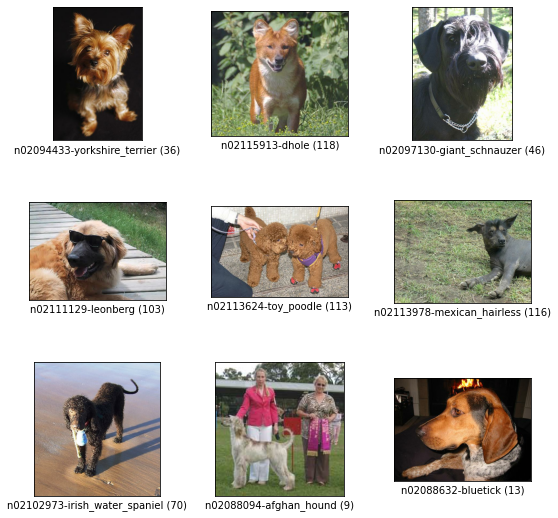

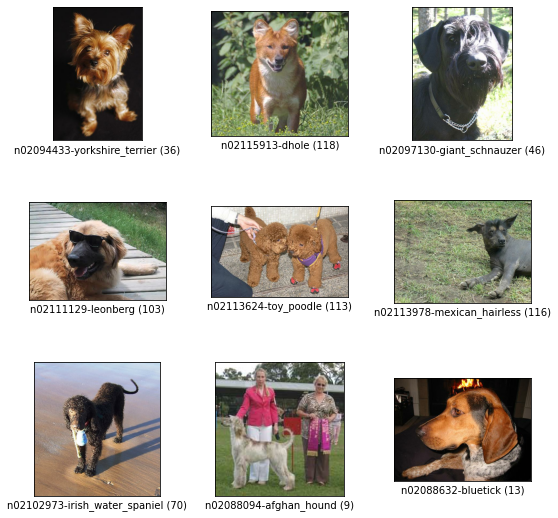

In [ ]:
# 다운로드한 데이터 확인
tfds.show_examples(ds_train, ds_info)

In [ ]:
transforms = Compose([GaussNoise(var_limit=(0, 20.0)),
                      HorizontalFlip()
                      ])

In [ ]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [ ]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [ ]:
# create dataset
ds_alb = ds_train.map(partial(process_data, img_size=224),
                  num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
ds_alb

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
def set_shapes(img, label, img_shape=(224,224,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

In [ ]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_alb

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

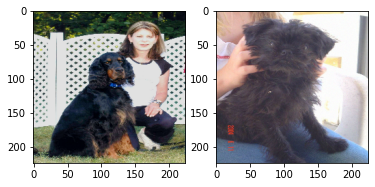

In [ ]:
# 배치 내의 이미지를 두 개 골라 섞어준다. 
# 데이터셋에서 이미지 2개를 가져온다. 
for i, (image, label) in enumerate(ds_alb.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
# 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, 
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
# 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    # 바탕 이미지(a)의 사이즈
    image_size_x = image_a.shape[1]  # 가로
    image_size_y = image_a.shape[0]  # 세로
    
    # get center of box
    # tf.random.uniform([], 0, image_size_x) : 0 ~ image_size_x까지 숫자를 랜덤하게 뽑아 배열을 만든다.
    # 배열 부분이 []인 경우 범위 내에서 숫자 하나만 뽑아낸다.
    # tf.cast() : tf.random.uniform()에서 만들어진 배열을 tf.int32 타입으로 변환
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    # tf.random.uniform([], 0, 1) : 0~1 사이 랜덤한 숫자 하나를 뽑아낸다.
    # 1-tf.random.uniform([], 0, 1) : 1 보다는 작은 실수 
    # tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32) : 제곱근을 구한다. 위에서 나온 값보다 더 작은 값이 반환된다.
    # 위에서 구한 값을 image_size_x에 곱한 후 해당 값을 tf.int32 타입으로 변환
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(33, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(156, shape=(), dtype=int32)


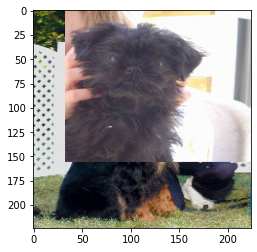

In [ ]:
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :]  # image_a의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]  # image_a의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)  # middle = image_a 왼쪽 바깥 영역 + image_b 안쪽 영역 + image_a 오른쪽 바깥 영역
    top = image_a[0:y_min, :, :]  # image_a의 위쪽
    bottom = image_a[y_max:image_size_y, :, :]  # image_a의 아래쪽
    mixed_img = tf.concat([top, middle, bottom],axis=0)  # 결과적으로는 image_a가 바탕, image_b의 잘린 부분이 image_a에 삽입
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
# 라벨 섞기
# CutMix에서는 면적에 비례해서 라벨을 섞어준다.
# 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더한다.
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)  # 삽입된 이미지의 면적
    total_area = image_size_x*image_size_y   # 바탕 이미지의 면적
    ratio = tf.cast(mixed_area/total_area, tf.float32)  # 바탕 이미지(a) 면적에서 삽입된 이미지(b)의 면적 비율

    if len(label_a.shape)==0:  # 라벨이 있다면
        label_a = tf.one_hot(label_a, num_classes)  # 라벨에 onehot encoding 적용
    if len(label_b.shape)==0:  # 라벨이 있다면
        label_b = tf.one_hot(label_b, num_classes)  # 라벨에 onehot encoding 적용
    mixed_label = (1-ratio)*label_a + ratio*label_b  # 라벨 또한 이미지의 면적 비율만큼 섞는다.
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.4061703, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [ ]:
# 위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size): # batch_size만큼 반복
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))  # mix_2_images() 적용 
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))  # mix_2_label() 적용

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
num_classes = ds_info.features["label"].num_classes

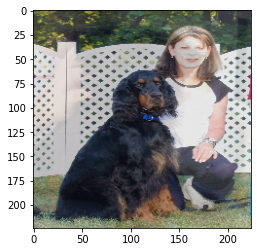

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.78632116 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)  # 0~1 사이 랜덤한 숫자 하나를 뽑아낸다.
    
    if len(label_a.shape)==0:  # 라벨이 있다면 
        label_a = tf.one_hot(label_a, num_classes)  # 라벨에 onehot encoding 적용
    if len(label_b.shape)==0:  # 라벨이 있다면 
        label_b = tf.one_hot(label_b, num_classes)  # 라벨에 onehot encoding 적용
    mixed_image= (1-ratio)*image_a + ratio*image_b  # 이미지를 일정 비율로 섞는다.
    mixed_label = (1-ratio)*label_a + ratio*label_b  # 라벨도 동일하게 섞는다.
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
# 위에서 구현한 함수를 활용하여 "배치 단위"의 mixup() 함수를 구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):  # barch_size만큼 반복한다.
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)  # 앞에서 구현한 함수 적용
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # tf.reshape(tensor, shape, name=None)
    # tf.stack() : 리스트 `mixed_imgs`, `mixed_labels`에 담긴 텐서들을 쌓아올린다.
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))  
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
# 입력받은 이미지를 0~1 사이의 float32로 normalize
# (224, 224) 사이즈로 resize
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

# CutMix와 Mixup을 적용할 수 있도록 변경한 apply_normalize_on_dataset()
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    # and 연산자 앞과 뒤 조건이 모두 True여야, if문이 실행된다.
    if not is_test and with_aug:  # 테스트셋이 아니고 with_aug 적용하고자 함
        ds = ds.map(partial(process_data, img_size=224),
                  num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
    
    ds = ds.batch(batch_size)  # Cutmix 적용하기 전 batch() 실행
    if not is_test and with_cutmix:  # 테스트셋이 아니고 with_cutmix를 적용하고자 한다.
        ds = ds.map(
            cutmix,  # cutmix 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:  # 테스트셋이 아니고 with_mixup을 적용하고자 한다.
        ds = ds.map(
            mixup,  # mixup 적용
            num_parallel_calls=2
        )
    else:  # 테스트셋이라면 onehot encoding 수행
        ds = ds.map(
            onehot, 
            num_parallel_calls=2
        )
    if not is_test:  # 테스트셋이 아니라면,
        ds = ds.repeat()  ######
        ds = ds.shuffle(200)  ######
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  ######
    return ds

In [ ]:
# apply_normalize_on_dataset((ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
# 1. Augmentation 적용하지 않은 데이터셋으로 학습시킬 ResNet
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# 2. 기본 Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 3. CutMix만 적용한 데이터셋으로 학습시킬 ResNet
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 4. Mixup만 적용한 데이터셋으로 학습시킬 ResNet
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
# 6. 기본 Augmentation + Mixup를 적용한 데이터셋으로 학습시킬 ResNet
resnet50_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,       # 마지막 fully connected layer를 포함하지 않고 특성 추출기(feature extractor) 부분만 불러온다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')   # 넣어주는 데이터에 맞게 수정된 fully connected layer를 붙여서 활용
])

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2022)

# 1. Augmentation 적용하지 않은 데이터셋 학습 모델
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 2. 기본 Augmentation을 적용한 데이터셋 학습 모델
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 3. CutMix만 적용한 데이터셋 학습 모델
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 4. Mixup만 적용한 데이터셋 학습 모델
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋 학습 모델
resnet50_aug_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 6. 기본 Augmentation + Mixup를 적용한 데이터셋 학습 모델
resnet50_aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# 1. Augmentation 적용하지 않은 데이터셋 학습
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # Augmentation 적용하지 않은 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 104s 118ms/step - loss: 2.1993 - accuracy: 0.4498 - top_k_categorical_accuracy: 0.7478 - val_loss: 3.1769 - val_accuracy: 0.2410 - val_top_k_categorical_accuracy: 0.5380
Epoch 2/20
750/750 [==============================] - 87s 116ms/step - loss: 0.6853 - accuracy: 0.8144 - top_k_categorical_accuracy: 0.9715 - val_loss: 1.0605 - val_accuracy: 0.6891 - val_top_k_categorical_accuracy: 0.9319
Epoch 3/20
750/750 [==============================] - 86s 115ms/step - loss: 0.1863 - accuracy: 0.9654 - top_k_categorical_accuracy: 0.9983 - val_loss: 0.9141 - val_accuracy: 0.7309 - val_top_k_categorical_accuracy: 0.9497
Epoch 4/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0449 - accuracy: 0.9973 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.8939 - val_accuracy: 0.7434 - val_top_k_categorical_accuracy: 0.9509
Epoch 5/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0200 - accuracy: 0.9998 - to

In [ ]:
# 2. 기본 Augmentation을 적용한 데이터셋 학습
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # 기본 Augmentation을 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 121s 144ms/step - loss: 4.0852 - accuracy: 0.1133 - top_k_categorical_accuracy: 0.2633 - val_loss: 4.1460 - val_accuracy: 0.1074 - val_top_k_categorical_accuracy: 0.3317
Epoch 2/20
750/750 [==============================] - 107s 143ms/step - loss: 3.2484 - accuracy: 0.2623 - top_k_categorical_accuracy: 0.4610 - val_loss: 59.9726 - val_accuracy: 0.0084 - val_top_k_categorical_accuracy: 0.0455
Epoch 3/20
750/750 [==============================] - 107s 143ms/step - loss: 2.9180 - accuracy: 0.3383 - top_k_categorical_accuracy: 0.5273 - val_loss: 1203.2748 - val_accuracy: 0.0071 - val_top_k_categorical_accuracy: 0.9999
Epoch 4/20
750/750 [==============================] - 107s 143ms/step - loss: 2.7167 - accuracy: 0.3783 - top_k_categorical_accuracy: 0.5534 - val_loss: 1948.1953 - val_accuracy: 0.0111 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/20
750/750 [==============================] - 108s 144ms/step - loss: 2.6199 - accuracy: 

In [ ]:
# 3. CutMix만 적용한 데이터셋 학습
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # CutMix만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 96s 119ms/step - loss: 3.8237 - accuracy: 0.2139 - top_k_categorical_accuracy: 0.4510 - val_loss: 3.4419 - val_accuracy: 0.2021 - val_top_k_categorical_accuracy: 0.4819
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 2.9349 - accuracy: 0.4380 - top_k_categorical_accuracy: 0.7122 - val_loss: 1.2546 - val_accuracy: 0.6377 - val_top_k_categorical_accuracy: 0.9186
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 2.6223 - accuracy: 0.5308 - top_k_categorical_accuracy: 0.7865 - val_loss: 1.2913 - val_accuracy: 0.6383 - val_top_k_categorical_accuracy: 0.9107
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 2.4389 - accuracy: 0.5930 - top_k_categorical_accuracy: 0.8242 - val_loss: 1.1879 - val_accuracy: 0.6674 - val_top_k_categorical_accuracy: 0.9235
Epoch 5/20
750/750 [==============================] - 89s 118ms/step - loss: 2.2806 - accuracy: 0.6476 - top

In [ ]:
# 4. Mixup만 적용한 데이터셋 학습
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 3.7065 - accuracy: 0.2429 - top_k_categorical_accuracy: 0.5073 - val_loss: 3.6585 - val_accuracy: 0.1761 - val_top_k_categorical_accuracy: 0.4050
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.8293 - accuracy: 0.4854 - top_k_categorical_accuracy: 0.7757 - val_loss: 1.4193 - val_accuracy: 0.5969 - val_top_k_categorical_accuracy: 0.8983
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.5364 - accuracy: 0.6008 - top_k_categorical_accuracy: 0.8332 - val_loss: 1.2812 - val_accuracy: 0.6368 - val_top_k_categorical_accuracy: 0.9079
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 2.3787 - accuracy: 0.6588 - top_k_categorical_accuracy: 0.8648 - val_loss: 1.3017 - val_accuracy: 0.6431 - val_top_k_categorical_accuracy: 0.9026
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 2.2275 - accuracy: 0.7232 - top

In [ ]:
# 5. 기본 Augmentation + Cutmix를 적용한 데이터셋 학습
history_resnet50_aug_cutmix = resnet50_aug_cutmix.fit(
    ds_train_aug_cutmix, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 127s 152ms/step - loss: 4.6573 - accuracy: 0.0406 - top_k_categorical_accuracy: 0.1275 - val_loss: 4.5776 - val_accuracy: 0.0642 - val_top_k_categorical_accuracy: 0.2014
Epoch 2/20
750/750 [==============================] - 113s 151ms/step - loss: 4.2436 - accuracy: 0.1198 - top_k_categorical_accuracy: 0.2844 - val_loss: 47.5199 - val_accuracy: 0.0115 - val_top_k_categorical_accuracy: 0.0437
Epoch 3/20
750/750 [==============================] - 113s 151ms/step - loss: 4.0420 - accuracy: 0.1728 - top_k_categorical_accuracy: 0.3550 - val_loss: 1227.0894 - val_accuracy: 0.0111 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/20
750/750 [==============================] - 113s 151ms/step - loss: 3.9062 - accuracy: 0.2193 - top_k_categorical_accuracy: 0.3957 - val_loss: 1078.3046 - val_accuracy: 0.0084 - val_top_k_categorical_accuracy: 0.9993
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 3.8174 - accuracy: 

In [ ]:
# 6. 기본 Augmentation + Mixup를 적용한 데이터셋 학습
history_resnet50_aug_mixup = resnet50_aug_mixup.fit(
    ds_train_aug_mixup, # Mixup만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 127s 152ms/step - loss: 4.6881 - accuracy: 0.0347 - top_k_categorical_accuracy: 0.1115 - val_loss: 4.0234 - val_accuracy: 0.1178 - val_top_k_categorical_accuracy: 0.3166
Epoch 2/20
750/750 [==============================] - 118s 157ms/step - loss: 4.2227 - accuracy: 0.1183 - top_k_categorical_accuracy: 0.2962 - val_loss: 64.9705 - val_accuracy: 0.0071 - val_top_k_categorical_accuracy: 0.0392
Epoch 3/20
750/750 [==============================] - 118s 157ms/step - loss: 4.0271 - accuracy: 0.1799 - top_k_categorical_accuracy: 0.3668 - val_loss: 766.8491 - val_accuracy: 0.0098 - val_top_k_categorical_accuracy: 0.9993
Epoch 4/20
750/750 [==============================] - 113s 150ms/step - loss: 3.8847 - accuracy: 0.2195 - top_k_categorical_accuracy: 0.4118 - val_loss: 891.0757 - val_accuracy: 0.0062 - val_top_k_categorical_accuracy: 0.9721
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 3.8032 - accuracy: 0.

### 훈련과정 시각화

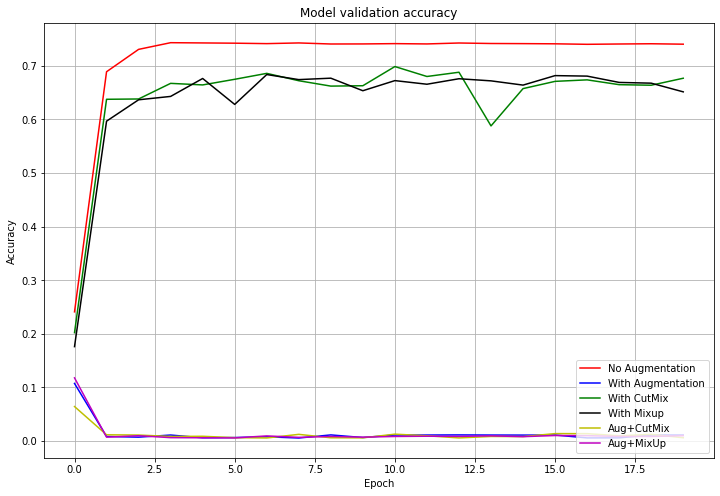

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup', 'Aug+CutMix', 'Aug+MixUp'], loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# val_accuracy
acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy'],
            'Aug+CutMix': history_resnet50_aug_cutmix.history['val_accuracy'],
            'Aug+MixUp': history_resnet50_aug_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
0,0.241021,0.107393,0.202076,0.176073,0.064249,0.117771
1,0.689132,0.008396,0.637710,0.596898,0.011544,0.007113
2,0.730877,0.007113,0.638293,0.636777,0.011077,0.009795
3,0.743354,0.011077,0.667444,0.643074,0.008396,0.006180
4,0.742887,0.005947,0.664529,0.676539,0.008745,0.005947
5,0.742421,0.006413,0.675023,0.628148,0.006180,0.005714
6,0.741605,0.007812,0.686101,0.683885,0.005597,0.009445
7,0.742887,0.005480,0.672341,0.674440,0.012360,0.006763
8,0.740905,0.011311,0.662313,0.677122,0.005947,0.008396
9,0.741021,0.006413,0.663013,0.653685,0.005830,0.007113


In [ ]:
acc_df.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.713468,0.013882,0.641645,0.637442,0.011999,0.013724
std,0.111834,0.022137,0.106034,0.110731,0.012616,0.024529
min,0.241021,0.005480,0.202076,0.176073,0.005597,0.005714
25%,0.740817,0.006413,0.661147,0.649458,0.006151,0.007113
50%,0.741313,0.011019,0.666220,0.668493,0.009212,0.008454
75%,0.741983,0.011077,0.675519,0.676189,0.012273,0.009620
max,0.743354,0.107393,0.698811,0.683885,0.064249,0.117771


In [ ]:
# val_top5 accuracy
topkacc_data = {'No Augmentation': history_resnet50_no_aug.history['val_top_k_categorical_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_top_k_categorical_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_top_k_categorical_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_top_k_categorical_accuracy'],
            'Aug+CutMix': history_resnet50_aug_cutmix.history['val_top_k_categorical_accuracy'],
            'Aug+MixUp': history_resnet50_aug_mixup.history['val_top_k_categorical_accuracy']}
topkacc_data = pd.DataFrame(topkacc_data)
topkacc_data

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
0,0.538013,0.331740,0.481926,0.404967,0.201376,0.316581
1,0.931903,0.045476,0.918610,0.898321,0.043727,0.039179
2,0.949743,0.999883,0.910681,0.907882,1.000000,0.999300
3,0.950909,1.000000,0.923507,0.902635,0.999300,0.972132
4,0.950909,1.000000,0.918493,0.923158,1.000000,0.987990
5,0.950909,1.000000,0.925606,0.898204,1.000000,0.981227
6,0.949510,0.999650,0.921642,0.920476,0.999184,0.822178
7,0.949977,1.000000,0.915229,0.917677,0.940998,1.000000
8,0.949860,0.696595,0.913130,0.916278,0.991721,0.912197
9,0.949044,1.000000,0.916744,0.905434,1.000000,0.999300


In [ ]:
topkacc_data.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup,Aug+CutMix,Aug+MixUp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.927699,0.903667,0.889815,0.884369,0.906792,0.901131
std,0.091810,0.257942,0.097474,0.113076,0.269783,0.254988
min,0.538013,0.045476,0.481926,0.404967,0.043727,0.039179
25%,0.948169,0.999971,0.906542,0.904035,0.992421,0.978953
50%,0.948986,1.000000,0.914179,0.908174,0.999242,0.999242
75%,0.949773,1.000000,0.919455,0.916307,0.999913,0.999913
max,0.950909,1.000000,0.928755,0.923158,1.000000,1.000000
